In [1]:
import os
import time
from math import log

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


t = time.time()

In [2]:
class Modelisation():
    def __init__(self, X, y, model, scaling=True):
        if scaling:
            scaler = StandardScaler()
            X = scaler.fit_transform(X)

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=1234)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        cm = confusion_matrix(y_test, y_pred)
        probs = model.predict_proba(X_test)[:, 1]
        
        TP = cm[1][1]
        FN = cm[0][1]
        FP = cm[1][0]
        TN = cm[0][0]
        sc_roc_auc = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

        # Recall
        Recall = TP/(TP+FN)
        # Precision
        Precision = TP/(TP+FP)
        # Negative predictive value
        NPV = TN/(TN+FN)
        # F1_Score
        F1 = (2*Precision*Recall)/(Precision+Recall)

        metrics_score = {'f1': F1, 'recall': Recall,'negative predictive value': NPV,'precision': Precision, 'roc_auc': sc_roc_auc}

        self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test
        self.model = model
        self.probs = probs
        self.metrics_score = metrics_score
        self.recall = Recall

    def get_data(self):
        return self.X_train, self.X_test, self.y_train, self.y_test
    
    def show_conf_matrix(self):
        metrics.plot_confusion_matrix(self.model, self.X_test, self.y_test, cmap='Blues')
        plt.show()     
    
    def show_metrics_score(self):
        for key, value in self.metrics_score.items():
            print(f"{key} : {value:.4f}")
            
    def show_ROC(self):
        fpr, tpr, _ = metrics.roc_curve(self.y_test, self.probs)
        plt.plot(fpr, tpr, label=f"{self.model}")
        plt.plot([0, 1], [0, 1], "r-", label='Modèle aléatoire')
        plt.plot([0, 0, 1], [0, 1, 1], 'b-', label='Modèle parfait')
        plt.legend()
        plt.title('Courbe ROC')
        plt.show()
    
    def show_recall(self): 
        return self.recall

Afin de comparer nos modèles en termes de performances brutes et de temps d'exécution, il est fondamental de déterminer quelques métriques de référence. Ici, il faut surtout faire en sorte d'éviter de prédire des non-clics qui seraient en réalité des clics (ie prédire trop de 0), quitte à prédire trop de 1. Autrement dit, il faut maximiser le recall et le NPV (Negative predictive value) afin de limiter les erreurs de type II. Le F1 Score, combinaison du recall et de la précision, est également pertinent. 

In [3]:
df = pd.read_csv('data/df_train_prepro.csv').sample(frac=1)
df.shape

(1610494, 50)

## Variables quantitatives

In [4]:
columns_quant = ['contextid',
 'campaignctrlast24h',
 'dayssincelastvisitdouble',
 'ltf_nbglobaldisplay_4w',
 'ltf_nbpartnerdisplayssincelastclick',
 'ltf_nbpartnerdisplay_90d',
 'ltf_nbpartnerclick_90d',
 'ltf_nbpartnersales_90d',
 'nbdayssincelastclick',
 'nbdisplay_1hour',
 'nbdisplayglobalapprox_1d_sum_xdevice',
 'display_size',
 'zonecostineuro']

X = df[columns_quant]
y = df['is_display_clicked']

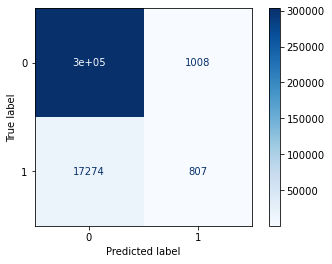

f1 : 0.0811
recall : 0.4446
negative predictive value : 0.9967
precision : 0.0446
roc_auc : 0.7378


In [5]:
m = Modelisation(X, y, LogisticRegression())
m.show_conf_matrix()
m.show_metrics_score()

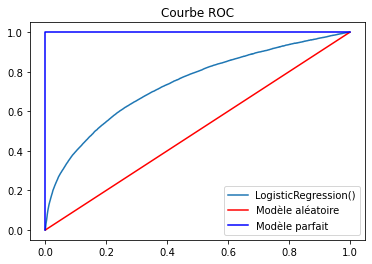

In [6]:
m.show_ROC()

In [7]:
coeff_df = pd.DataFrame(np.transpose(m.model.coef_), X.columns, columns=['Coefficient'])
coeff_df

,Coefficient
contextid,-0.024836
campaignctrlast24h,0.361167
dayssincelastvisitdouble,-0.026874
ltf_nbglobaldisplay_4w,0.012251
ltf_nbpartnerdisplayssincelastclick,-0.026969
ltf_nbpartnerdisplay_90d,-0.008785
ltf_nbpartnerclick_90d,0.028820
ltf_nbpartnersales_90d,-0.010025
nbdayssincelastclick,-0.112318
nbdisplay_1hour,-0.222089


In [8]:
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant

X_ = add_constant(X)
print(Logit(y, X_).fit().summary())

Optimization terminated successfully.
         Current function value: 0.197126
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:     is_display_clicked   No. Observations:              1610494
Model:                          Logit   Df Residuals:                  1610480
Method:                           MLE   Df Model:                           13
Date:                Wed, 20 Jan 2021   Pseudo R-squ.:                 0.09804
Time:                        01:50:12   Log-Likelihood:            -3.1747e+05
converged:                       True   LL-Null:                   -3.5198e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                   -3.7845      0.0

Avec LASSO : 

In [9]:
X1 = df[['contextid',
         'dayssincelastvisitdouble',
         'campaignctrlast24h',
         'nbdisplay_1hour',
         'nbdayssincelastclick',
         'display_size',
         'nbdisplayglobalapprox_1d_sum_xdevice']]
y1 = df['is_display_clicked']

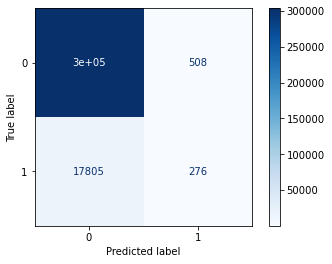

f1 : 0.0293
recall : 0.3520
negative predictive value : 0.9983
precision : 0.0153
roc_auc : 0.6850


In [10]:
m1 = Modelisation(X1, y1, LogisticRegression())
m1.show_conf_matrix()
m1.show_metrics_score()

# Categorical variables

In [11]:
columns_cat = ['display_env',
            'target_env',
#             'user_country', 
            'campaignscenario',
            'campaignvertical',
            'is_interstitial',
            'device_type']

In [12]:
# Nombre de valeurs distinctes
for column in columns_cat:
    print(f"{column} : {len(set(df[column]))}")

display_env : 4
target_env : 2
campaignscenario : 7
campaignvertical : 34
is_interstitial : 3
device_type : 7


In [13]:
df_cat = pd.get_dummies(df[columns_cat], columns=columns_cat, drop_first=True)
len(df_cat.columns)

21

In [14]:
X = df_cat
y = df['is_display_clicked']

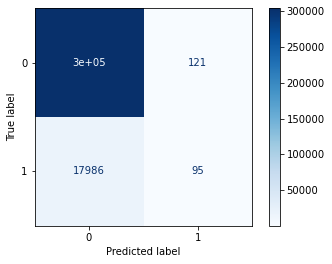

f1 : 0.0104
recall : 0.4398
negative predictive value : 0.9996
precision : 0.0053
roc_auc : 0.6849


In [15]:
m = Modelisation(X, y, LogisticRegression())
m.show_conf_matrix()
m.show_metrics_score()

## Quantitative + categorical

In [16]:
df_temp = df[columns_quant + columns_cat]
df_temp = pd.get_dummies(df_temp, columns=columns_cat, drop_first=True)
len(df_temp.columns)

34

In [17]:
X = df_temp
y = df['is_display_clicked']

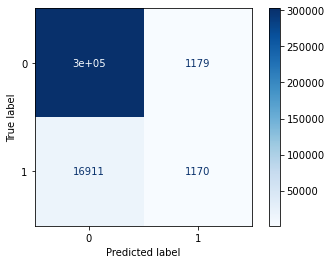

f1 : 0.1145
recall : 0.4981
negative predictive value : 0.9961
precision : 0.0647
roc_auc : 0.7548
Wall time: 9.67 s


In [18]:
%%time
m = Modelisation(X, y, LogisticRegression())
m.show_conf_matrix()
m.show_metrics_score()

## Comparaison par rapport aux valeurs de C 

In [19]:
X = df_temp
y = df['is_display_clicked']

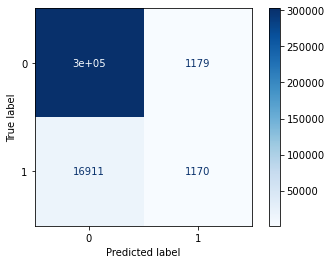

f1 : 0.1145
recall : 0.4981
negative predictive value : 0.9961
precision : 0.0647
roc_auc : 0.7548


In [22]:
m = Modelisation(X, y, LogisticRegression(C=0.2))
m.show_conf_matrix()
m.show_metrics_score()

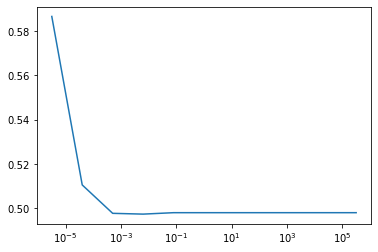

In [23]:
C, list_recall = [], []
for c in np.logspace(-5.5, 5.5, num = 11): 
    m = Modelisation(X, y, LogisticRegression(C=c))
    C.append(c)
    list_recall.append(m.show_recall())
plt.plot(C, list_recall)
plt.xscale('log')
plt.show()

In [24]:
print(f"Temps d'exécution total : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}")

Temps d'exécution total : 00:11:53
